### Find inverse traces
This notebook shows now to predict inverse trace using first break piking model and Random Trees.

### Task description
Some traces may be inversed because of the sensor failure. Using first break piking model and some features from traces we train RandomForest to solve the problem.

### Generated dataset discription
Let's have a look on the features that will be used for inverse traces detection. The dataset consist the following params:
* the amplitude value at the point of the first break picking
* offset
* correlation between part of traces centered by linear interpolated first break picking points.
* correlation between part of traces centered by first break picking points.

In [1]:
import sys
import torch
import segyio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, classification_report

sys.path.append('../..')

from seismicpro.batchflow import Pipeline, Dataset, B
from seismicpro.batchflow.models.torch import UNet
from seismicpro.src import (SeismicBatch, FieldIndex, TraceIndex, 
                            merge_picking_files, seismic_plot, KNNIndex)
from inverse_batch import InverseBatch, predict, crop_trace
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


### Data

Firstly have a look on the data. Let's draw some of traces and try to guess the inverse trace.

In [18]:
path_raw = '/notebooks/egor/FB/Pal/Pal_Flatiron_1k.sgy'

index = (FieldIndex(name='raw', path=path_raw, extra_headers=['offset']))
index = index.create_subset(index.indices[:1])
batch = (Dataset(FieldIndex((index)), InverseBatch).p
         .load(components='raw', fmt='segy')
         ).next_batch(1)

field = batch.raw[0]
mask = np.ones(len(field))
ix = np.random.choice(len(mask))
mask[ix] = -1
inv_field = np.array([trace * mask[i] for i, trace in enumerate(field)])

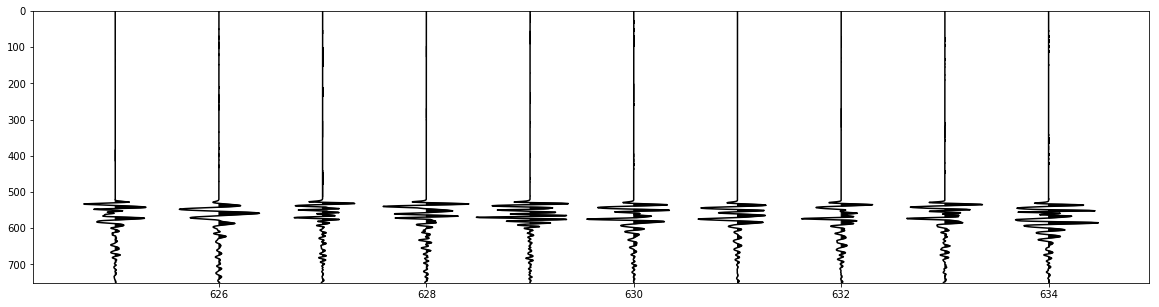

In [19]:
left = np.random.randint(0, 10)
right = 10 - left
seismic_plot(inv_field, cmap='gray', wiggle=True, vmax=.1, cmin=-0.1,
             figsize=(20, 5), std=0.1, xlim=(ix-left, ix+right))

In [20]:
print('Inverse trace is {}.'.format(ix))

Inverse trace is 625.


### Preprocessing

Firstly we load pretrained first break piking model.

In [5]:
model_path = '/notebooks/kalashnikov/geolog/models/First_break_picking/picks_modelUNet_ker5.dill'

model_ppl = Pipeline().init_model('dynamic', UNet, 'my_model',
                            config={'load' : {'path' : model_path},
                                    'build': False, 'device': 'cuda'})

model = model_ppl.get_model_by_name('my_model').model

#### Features
Here we will draw an examples of features. Two images  consist examples of traces on which correlations are considered.

In [75]:
def f(a):
    return (a - a.mean())/a.std()

offset = np.array(index.get_df(index=index.indices[0])['offset'])
field = batch.raw[0]
field = np.apply_along_axis(f, 1, field)
amp = []

for trace in tqdm(field):
    tr = torch.Tensor(trace).reshape(1, 1, -1).to('cuda')
    amp.append(predict(tr, model))

100%|██████████| 840/840 [00:05<00:00, 161.34it/s]


In [77]:
lr = LinearRegression()
data_tr = np.stack((offset, np.ones(len(offset)))).T
target = np.array(amp).reshape(-1, 1)
lr.fit(data_tr, target)
off_pred = [int(lr.predict([[off, 1]])[0][0]) for off in offset]

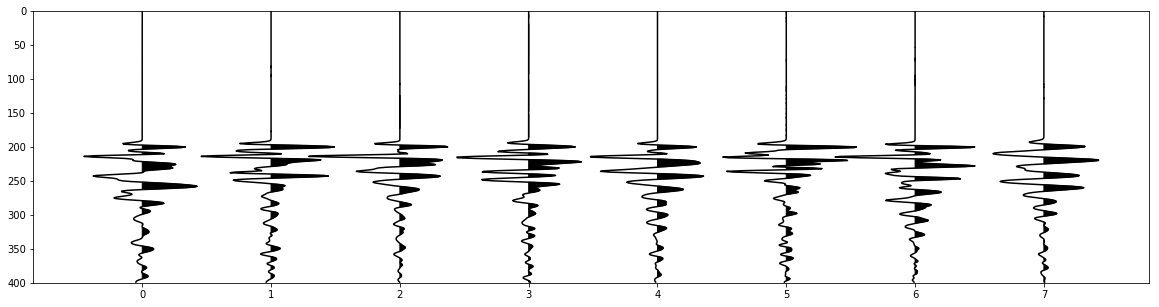

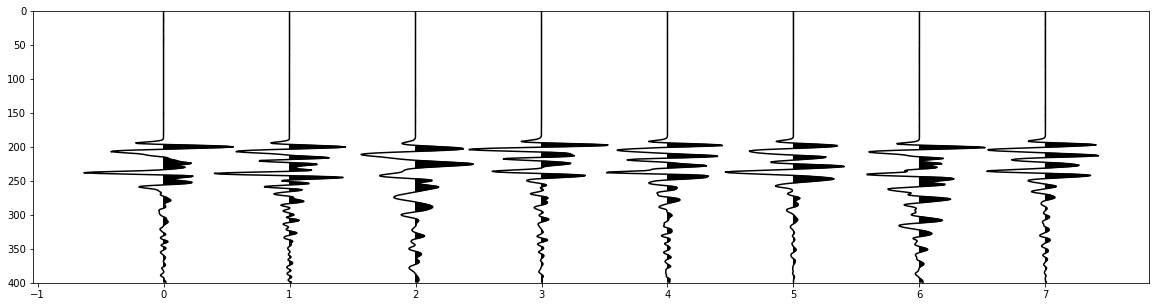

In [79]:
SIZE = 400
ix_pred = np.random.choice(range(5, len(pred)-5))
ix_pred = range(ix_pred-4, ix_pred+4)
ix_lr = np.random.choice(range(5, len(off_pred)-5))
ix_lr = range(ix_lr-4, ix_lr+4)
for type_ix, type_pred in zip([ix_pred, ix_lr], [pred, off_pred]):
    traces = []
    p = []
    for trace_ix in type_ix:
        traces.append(crop_trace(field[trace_ix], type_pred[trace_ix], SIZE))
        p.append(type_pred[trace_ix])
    pts = (range(len(p)), p)
    seismic_plot(np.array(traces), cmap='gray', wiggle=True, vmax=.1, cmin=-0.1,
                 figsize=(20, 5), std=0.1)

Define pipeline and generate the dataset.

In [6]:
N_NEIGH = 10

def f(a):
    return (a - a.mean())/a.std()

ppl = (Dataset(index, InverseBatch).p
         .load(components='raw', fmt='segy')
         .init_variable('diff', init_on_each_run=list)
         .apply_transform(f, src='raw')
         .generate_inverse_dataset(model, num_neig=N_NEIGH, src='raw',
                                   size=SIZE, dst='diff')
         .update_variable('diff', B('diff'), mode='e')
        )

Split dataset on train and test.

In [7]:
%%time
z = ppl.next_batch(10)

diff = ppl.get_variable('diff')
data = np.concatenate(diff)

np.random.shuffle(data)
dataset, target = data[:,:-1], data[:,-1]
dataset = np.nan_to_num(dataset)

X_train, X_test, y_train, y_test = train_test_split(dataset, target)

CPU times: user 13min 29s, sys: 4min 23s, total: 17min 52s
Wall time: 9min 29s


Have a look on the dataset.

In [8]:
gen_name = lambda name, n: [name + '_{}'.format(i) for i in range(n)]
columns = ['amplitude', 'offset', *gen_name('of_corr_left', N_NEIGH),
           *gen_name('of_corr_right', N_NEIGH), *gen_name('of_inv_corr_left', N_NEIGH),
           *gen_name('of_inv_corr_right', N_NEIGH), *gen_name('corr_left', N_NEIGH),
           *gen_name('corr_right', N_NEIGH), 
           *gen_name('inv_corr_left', N_NEIGH), *gen_name('inv_corr_right', N_NEIGH)]
df = pd.DataFrame(X_train, columns=columns)
print('Dataset shape is: {}\n'.format(df.shape))
df.head()

Dataset shape is: (12580, 82)



,amplitude,offset,of_corr_left_0,of_corr_left_1,of_corr_left_2,of_corr_left_3,of_corr_left_4,of_corr_left_5,of_corr_left_6,of_corr_left_7,...,inv_corr_right_0,inv_corr_right_1,inv_corr_right_2,inv_corr_right_3,inv_corr_right_4,inv_corr_right_5,inv_corr_right_6,inv_corr_right_7,inv_corr_right_8,inv_corr_right_9
0,1.889250,828.0,0.470137,-0.680314,-0.896004,0.243269,-0.930988,0.964944,0.935447,0.396947,...,0.899830,0.795113,0.896991,0.890234,0.583963,0.805020,0.648156,0.120102,0.927474,0.840640
1,1.510725,1644.0,-0.763240,0.352636,-0.867405,-0.744298,-0.451629,-0.678627,-0.704140,-0.665911,...,0.790286,-0.108385,0.914526,0.852448,0.862796,0.097354,0.662452,0.949459,0.979484,0.992598
2,1.036844,1667.0,-0.341746,0.295960,0.044530,0.346107,-0.357233,-0.793212,-0.821021,-0.795255,...,0.987747,0.951694,0.466935,0.985718,0.826802,0.986758,0.876503,0.981916,0.970125,0.150590
3,1.733280,1935.0,-0.253773,-0.546970,0.727645,0.921103,0.758218,0.691748,0.467641,0.810713,...,0.231105,0.832079,0.763825,-0.074252,0.604487,0.683046,-0.093126,0.712179,-0.212911,0.924810
4,1.546379,1851.0,-0.497177,0.451496,0.489159,0.671382,0.751850,-0.216934,-0.149574,0.395728,...,0.788267,0.870067,0.858853,0.935539,0.567694,0.980856,0.974433,0.928972,0.734838,0.980192


### Train Model
Using dataset generated above let's train Random Forest alghoritm.

In [9]:
tree = RandomForestClassifier(n_estimators=200, n_jobs=4)
tree.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Now let's check the model quality. 

In [10]:
pred = tree.predict(X_test)
print(classification_report(y_test, pred))
print('Accuracy score: {:.3}'.format(accuracy_score(y_test, pred)))

             precision    recall  f1-score   support

        0.0       0.98      0.98      0.98      2121
        1.0       0.98      0.98      0.98      2073

avg / total       0.98      0.98      0.98      4194

Accuracy score: 0.976


And graw feature importance.

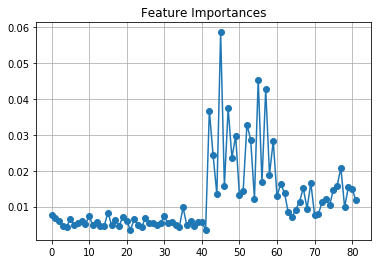

In [11]:
plt.title('Feature Importances')
plt.plot(range(len(tree.feature_importances_)),
         tree.feature_importances_, marker='o')
plt.grid()

### Predict on one field

Let's inverse some traces in one filed and check how the model will find inverse traces.

In [12]:
ppl = (Dataset(index, InverseBatch).p
         .load(components='raw', fmt='segy')
         .init_variable('diff', init_on_each_run=list)
         .apply_transform(f, src='raw')
         .generate_inverse_dataset(model, num_neig=N_NEIGH, src='raw',
                                   mode='predict', size=SIZE, dst='diff')
         .update_variable('diff', B('diff'), mode='e')
        )

In [13]:
batch = ppl.next_batch(1)

pred_diff = ppl.get_variable('diff')
pred_data = np.concatenate(pred_diff)

pred_dataset, pred_target = pred_data[:, : -1], pred_data[:, -1]
pred_dataset = np.nan_to_num(pred_dataset)

pred = tree.predict(pred_dataset)

In [14]:
print(classification_report(pred_target, pred))
print('Accuracy score: {:.3}'.format(accuracy_score(pred_target, pred)))
print('Number of inverse traces: {}'.format(sum(pred_target)))
print('Number of predict inverse traces: {}'.format(sum(pred)))
false_neg = sum(pred_target[np.where(pred_target != target)])
print('Number of missed inverse traces: {}'.format(false_neg))

             precision    recall  f1-score   support

        0.0       1.00      0.99      1.00       838
        1.0       0.20      1.00      0.33         2

avg / total       1.00      0.99      0.99       840

Accuracy score: 0.99
Number of inverse traces: 2.0
Number of predict inverse traces: 10.0
Number of missed inverse traces: 0.0


One can notice that there are many false positive predictions and zero false negative.